In [1]:
#standard Data Science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict

#import gensim stuff
from gensim import corpora, models, similarities, matutils
#import sklearn utilities
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

#yellowbrick visualization
from yellowbrick.features import Rank2D
from yellowbrick.regressor import ResidualsPlot

#import regression algorithms
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from sklearn.linear_model import Lasso, LassoCV, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import scipy.stats as stats
import xgboost as xgb

#NLP imports
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

#other
import logging
import string
import nltk
nltk.download('punkt')

%matplotlib inline
sns.set()

E:\Nicolas\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nicolas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Importing the Data ###  
  
The data was obtained from Google's Patent data on BigQuery

In [2]:
patents_abstract_sub=pd.read_csv(r'E:\Nicolas\Documents\Metis\patent\patent_abstract_sample.csv')
patents_abstract_sub.head()

,id,type,number,country,date,abstract,title,kind,num_claims,filename
0,7545023,utility,7545023,US,2009-06-09,A semiconductor transistor includes a substrat...,Semiconductor transistor,B2,10,ipg090609.xml
1,7819748,utility,7819748,US,2010-10-26,A display section <b>12</b> covered with a tou...,Game apparatus and storage medium storing game...,B2,14,ipg101026.xml
2,8104290,utility,8104290,US,2012-01-31,The present invention are directed towards a s...,Combustion liner damper,B2,5,ipg120131.xml
3,5865182,utility,5865182,US,1999-02-02,An improved viewing device which includes an ...,Positionable viewing shield with disposable tr...,A,11,pftaps19990202_wk05.zip
4,D750715,design,D750715,US,2016-03-01,NaN,Stationary bike,S1,1,ipg160301.xml


In [3]:
patents_abstract_sub['date'] = pd.to_datetime(patents_abstract_sub['date'])
patents_abstract_sub = patents_abstract_sub.sort_values(by='date')
patents_abstract_sub.head()

,id,type,number,country,date,abstract,title,kind,num_claims,filename
31021,3931068,utility,3931068,US,1976-01-06,Blends comprising biodegradable thermoplastic...,Blends of biodegradable thermoplastic oxyalkan...,A,28,pftaps19760106_wk01.zip
113488,3930762,utility,3930762,US,1976-01-06,A gas compressor or blower comprising a cylin...,Apparatus for use as a gas compressor or gas b...,A,3,pftaps19760106_wk01.zip
161404,3930973,utility,3930973,US,1976-01-06,"A method and apparatus for electrophoresis, c...",Electrophoretic process,A,4,pftaps19760106_wk01.zip
61566,3930478,utility,3930478,US,1976-01-06,An exhaust gas-detoxicating system for an ext...,System for the detoxication of exhaust gases,A,10,pftaps19760106_wk01.zip
36194,3931539,utility,3931539,US,1976-01-06,A superorthicon-type television camera tube w...,Superorthicon-type television camera tube havi...,A,8,pftaps19760106_wk01.zip


### Dealing with Null values ##

In [4]:
patents_abstract_sub.isnull().sum()

id                0
type              0
number            0
country           0
date              0
abstract      18101
title             6
kind              0
num_claims        0
filename          0
dtype: int64

In [5]:
patents_abstract_sub = patents_abstract_sub.dropna(how='any')

In [6]:
abstracts = patents_abstract_sub['abstract']

In [7]:
patents_abstract_sub.isnull().sum()

id            0
type          0
number        0
country       0
date          0
abstract      0
title         0
kind          0
num_claims    0
filename      0
dtype: int64

## Natural Language Processing ##  
  
The purpose of the natural language processing at the start was to do topic modelling on the abstracts to see what kind of groups we would naturally get. Would they be mostly patent topics, or can we gain deeper information? Does processing the abstracts give us different information than we can get from the titles alone? What is the sweet spot for the amount of topics? 


The first lesson I learned was that many words had to be filtered out through the use of a custom list of stop words, due to many URLs showing up, as well as words such as "product", "relates", "represents" , "novel", etc. which showed up regardless of the settings on the TF/IDF vectorizer. I wanted to make sure all topics were separable and sensical if they are to be used as features in a regression. 

In [8]:
additional_stops = ['http', 'www', 'br', 'gp', 'com', 'href', 've', 'don', 'product', 'bit', '10', 'ch', 'al', 'nh', 'invention', 'relates', 'str1', 'sup', 'sub', 'represents', 'relates', 'novel', 'useful', 'general', 'provides', 'first', 'second', 'r', 'rsup', 'rsub', 'b', 'bb']
stop_words = ENGLISH_STOP_WORDS.union(additional_stops)

In [9]:
def custom_tokenizer(text):

    # remove punctuation
    remove_punct = str.maketrans('', '', string.punctuation)
    text = text.translate(remove_punct)

    # remove digits and convert to lower case
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)

    # tokenize
    tokens = word_tokenize(text)

    # remove stop words
    tokens_stop = [y for y in tokens if y not in stop_words]

    # stem
    stemmer = SnowballStemmer('english')
    tokens_stem = [stemmer.stem(y) for y in tokens_stop] 

    return tokens_stem


In [10]:
tfidf = TfidfVectorizer(ngram_range=(1, 1),
                        analyzer='word',
                        tokenizer=custom_tokenizer,
                        strip_accents='unicode',
                        max_df=0.05
                       )

In [11]:
tfidf_vec = tfidf.fit_transform(abstracts)
tfidf_vec.shape

(181893, 121488)

In [12]:
nmf = NMF(100)
abstract_vecs = nmf.fit_transform(tfidf_vec)

In [13]:
abstract_features = tfidf.get_feature_names()
abstract_topics = [[abstract_features[idx] for idx in np.flip(np.argsort(component)[-20:], axis=0)] for component in nmf.components_]

In [14]:
topic_names = [[abstract_features[idx] for idx in np.flip(np.argsort(component)[-2:], axis=0)] for component in nmf.components_]

In [15]:
## Custom function to display the words in each topic

def print_topics(topics):
    for i,topic in enumerate(topics):
        print("Topic {}".format(i))
        print(", ".join(topic)+"\n")

In [16]:
## Place all topics in a dataframe so they can be used as features down the line

def topic_dataframe(topics):
        df_topics = [", ".join(topic) for i,topic in enumerate(topics)]
        df_topics = pd.DataFrame(df_topics, columns=['topics'])
        df_topics['topic'] = df_topics.index
        return df_topics

In [17]:
df_topic = topic_dataframe(topic_names)
df_topic.head()

,topics,topic
0,"cylind, piston",0
1,"electrod, electrolyt",1
2,"comput, applic",2
3,"agent, treatment",3
4,"voltag, refer",4


I messed around a lot with the amount of topics. In the end I decided on 100 topics as this would give me more features to use in a regression, and hopefully more granularity in the results. 

In [18]:
print_topics(abstract_topics)

Topic 0
cylind, piston, rod, brake, hydraul, actuat, compress, forc, pump, spring, engin, bore, reciproc, axial, stroke, work, displac, movement, combust, movabl

Topic 1
electrod, electrolyt, piezoelectr, organ, negat, emit, discharg, common, cathod, transpar, plasma, pair, drain, potenti, capacit, lead, anod, face, resist, electrochem

Topic 2
comput, applic, program, file, execut, server, processor, instruct, request, manag, function, resourc, client, softwar, identifi, machin, virtual, system, servic, host

Topic 3
agent, treatment, treat, diseas, pharmaceut, patient, tissu, protein, therapeut, disord, implant, condit, antibodi, human, cancer, deriv, cathet, subject, medic, accept

Topic 4
voltag, refer, level, regul, capacitor, convert, compar, amplifi, dc, threshold, ac, bias, low, charg, rectifi, feedback, invert, adjust, compens, driver

Topic 5
optic, waveguid, reflect, wavelength, path, illumin, axi, emit, polar, refract, disc, amplifi, project, index, detector, diffract, mir

### Add Topics and Other Data to DataFrame ###

In [48]:
## Check topic distribution to make sure technologies are being split properly and we are not getting a catch-all topic

df = pd.DataFrame([])
df['topic']=[abstract_vec.argmax() for abstract_vec in abstract_vecs]
df['topic'].value_counts()

3     6941
85    6369
96    5761
84    4455
82    4197
99    4049
97    3981
14    3665
95    3662
7     3386
69    3287
94    3183
20    3158
90    3089
89    3007
73    2897
77    2781
42    2702
87    2635
59    2618
11    2519
40    2499
98    2302
5     2217
88    2210
58    2166
18    2080
49    2056
93    2044
86    2018
      ... 
48    1116
23    1104
63    1090
29    1090
27    1072
43    1067
51    1041
36     959
25     884
60     862
16     844
34     819
19     791
31     756
8      745
71     740
22     700
56     685
32     633
9      603
44     576
4      556
47     455
6      418
17     367
39     274
21     247
26     211
15     175
0        6
Name: topic, Length: 100, dtype: int64

In [49]:
df_patents = patents_abstract_sub.merge(df, on=df.index)
df_patents = df_patents.merge(df_topic, on='topic')
df_patents = df_patents.drop(['filename', 'key_0'], axis=1)
del df ## memory management
df_patents.head(2)

,id,type,number,country,date,abstract,title,kind,num_claims,topic,topics
0,3931068,utility,3931068,US,1976-01-06,Blends comprising biodegradable thermoplastic...,Blends of biodegradable thermoplastic oxyalkan...,A,28,85,"weight, polym"
1,3931224,utility,3931224,US,1976-01-06,New curable monomeric aromatic imidodicarboxy...,Aromatic imidodicarboxylic acid diallyl esters...,A,3,85,"weight, polym"


In [50]:
df_patent_values = pd.read_csv('patents.csv')
#df_cites = pd.read_csv('cites.csv')

E:\Nicolas\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
df_patent_values['number'] = df_patent_values['patnum']
df_patent_values = df_patent_values.drop('patnum', axis=1)
df_patent_values.head(2)

,fdate,idate,pdate,permno,class,subclass,ncites,xi,number
0,4/14/1919,1/5/1926,NaN,NaN,NaN,NaN,NaN,NaN,1568040
1,8/21/1923,1/5/1926,NaN,NaN,NaN,NaN,NaN,NaN,1568041


In [52]:
df_patent_values['number'] = df_patent_values['number'].astype('str')
df_patent_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6240106 entries, 0 to 6240105
Data columns (total 9 columns):
fdate       object
idate       object
pdate       object
permno      float64
class       object
subclass    object
ncites      float64
xi          float64
number      object
dtypes: float64(3), object(6)
memory usage: 428.5+ MB


In [53]:
df_patents = df_patents.merge(df_patent_values, how='left', on='number')
del df_patent_values
df_patents.head(2)

,id,type,number,country,date,abstract,title,kind,num_claims,topic,topics,fdate,idate,pdate,permno,class,subclass,ncites,xi
0,3931068,utility,3931068,US,1976-01-06,Blends comprising biodegradable thermoplastic...,Blends of biodegradable thermoplastic oxyalkan...,A,28,85,"weight, polym",7/15/1974,1/6/1976,NaN,15659.0,524,014000O,32.0,5.21714
1,3931224,utility,3931224,US,1976-01-06,New curable monomeric aromatic imidodicarboxy...,Aromatic imidodicarboxylic acid diallyl esters...,A,3,85,"weight, polym",9/4/1973,1/6/1976,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
df_patents.isnull().sum()

id                 0
type               0
number             0
country            0
date               0
abstract           0
title              0
kind               0
num_claims         0
topic              0
topics             0
fdate          60514
idate          60513
pdate         147761
permno        137824
class         141091
subclass      141091
ncites        141074
xi            141074
dtype: int64

In [55]:
df_patents.shape

(181949, 19)

In [56]:
min(df_patents.xi)

0.00018025487952400002

### Addition of other data such as location, Government Influence, Assignee ###  
  
This data did not make it into the final project due to time constraints and memory issues with the computer I was using at the time. The code was written but not used as part of the final project at Metis. Here I have taken the time to fully implement it. 

In [57]:
df_location_assignee = pd.read_csv('location_assignee.csv')
df_location = pd.read_csv('location.csv')

E:\Nicolas\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
df_location = df_location.rename({'id': 'location_id'}, axis=1)
df_location_assignee = df_location_assignee.merge(df_location, how='left', on='location_id')
del df_location
df_location_assignee.head()

,location_id,assignee_id,city,state,country,latitude,longitude,county,state_fips,county_fips
0,0009wn7out97,cb7bfdd66aaff8564c567e62eec41de3,Kaiserslautern,NaN,DE,49.4123,7.69879,NaN,NaN,NaN
1,0009wn7out97,ddcdc6f48221e621c9e262864b08f0f5,Kaiserslautern,NaN,DE,49.4123,7.69879,NaN,NaN,NaN
2,0009wn7out97,7121a51c620049457d11c54df9508414,Kaiserslautern,NaN,DE,49.4123,7.69879,NaN,NaN,NaN
3,0009wn7out97,dfaffdd5e8be3aeb9e287440dba2bf34,Kaiserslautern,NaN,DE,49.4123,7.69879,NaN,NaN,NaN
4,0009wn7out97,7a61d241e1b77412a9f34a01dcbb8bb9,Kaiserslautern,NaN,DE,49.4123,7.69879,NaN,NaN,NaN


In [59]:
df_assignee = pd.read_csv('assignee.csv')
df_assignee = df_assignee.rename({'id':'assignee_id'}, axis=1)
df_assignee = df_assignee.merge(df_location_assignee, on='assignee_id', how ='left')
del df_location_assignee
df_assignee.head()

E:\Nicolas\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,assignee_id,type,name_first,name_last,organization,location_id,city,state,country,latitude,longitude,county,state_fips,county_fips
0,000692a7987648ea9f8d51f85fed9738,0,NaN,NaN,AC (MACAO COMMERCIAL OFFSHORE) LIMITED,ok3fhgna7d3a,Macao,NaN,MO,22.1980,113.5470,NaN,NaN,NaN
1,001b38ee6077e30760ded5db5667f100,0,NaN,NaN,MDC Corporation Inc.,codu114goyeu,Toronto,ON,CA,43.6515,-79.5350,NaN,NaN,NaN
2,001b38ee6077e30760ded5db5667f100,0,NaN,NaN,MDC Corporation Inc.,r96mcpdoahpp,Amherst,NY,US,42.9783,-78.8000,Erie,36.0,29.0
3,0023f73029027ad835df074973b7fca0,0,NaN,NaN,"PE Applied Biosystems, a division of Perkin-Elmer",ccy3of4ki4hk,Foster City,CA,US,37.5585,-122.2710,San Mateo,6.0,81.0
4,0036818a5ce5ffd604fc529574ede785,0,NaN,NaN,Alcolac Inc.,6dj79qf0u316,Pittsburgh,PA,US,40.4406,-79.9961,Allegheny,42.0,3.0


In [60]:
df_patent_assignee = pd.read_csv('patent_assignee.csv')
df_patent_assignee = df_patent_assignee.rename({'patent_id':'number'}, axis='columns')
df_patent_assignee = df_patent_assignee.merge(df_assignee, on='assignee_id', how='left')
del df_assignee
df_patent_assignee = df_patent_assignee.drop(['assignee_id', 'name_first', 'name_last', 'location_id', 'city', 'state', 'county', 'state_fips', 'county_fips'], axis=1)
df_patent_assignee = df_patent_assignee.dropna()
df_patent_assignee.head()

,number,type,organization,country,latitude,longitude
0,5711753,0,Allegheny-Singer Research Institute,US,40.4406,-79.9961
1,8070480,0,"Associated Physics of America, LLC",US,33.5161,-90.1794
2,6099859,0,"Andrx Pharmaceuticals, Inc.",US,32.7767,-96.7970
3,6099859,0,"Andrx Pharmaceuticals, Inc.",US,26.1223,-80.1434
4,6099859,0,"Andrx Pharmaceuticals, Inc.",US,26.1219,-80.1436


In [61]:
df_govt = pd.read_csv('govt.csv')
df_govt['gi'] = 1 ## add "yes or no" column for government influence
df_govt = df_govt.rename({'patent_id': 'number'}, axis='columns')
df_govt = df_govt.drop('gi_statement', axis=1)
df_patent_govt = df_patent_assignee.merge(df_govt, how='left', on='number')
del df_govt
del df_patent_assignee
df_patent_govt = df_patent_govt.dropna()
df_patent_govt.head()

,number,type,organization,country,latitude,longitude,gi
657,9208912,0,Afsaneh Rabiei,US,35.7719,-78.6389,1.0
2171,7436988,0,The Arizona Board of Regents,US,33.7298,-111.4310,1.0
2172,7436988,0,The Arizona Board of Regents,US,35.1981,-111.6510,1.0
2173,7436988,0,The Arizona Board of Regents,US,33.9703,-93.8828,1.0
2174,7436988,0,The Arizona Board of Regents,US,33.4147,-111.9090,1.0


In [63]:
df_patent_govt.shape

(1554173, 7)

In [64]:
df_patents = df_patents.dropna()
df_patents.isnull().sum()

id            0
type          0
number        0
country       0
date          0
abstract      0
title         0
kind          0
num_claims    0
topic         0
topics        0
fdate         0
idate         0
pdate         0
permno        0
class         0
subclass      0
ncites        0
xi            0
dtype: int64

In [65]:
len(df_patents['xi'])

13218

In [66]:
max(df_patents['ncites'])

225.0

I took the square root of the number of citations and claims and added them as features, in order to get a more even distribution.

In [67]:
df_patents['sqrt_ncites'] = np.sqrt(df_patents['ncites'])
df_patents['sqrt_claims'] = np.sqrt(df_patents['num_claims'])
df_patents['xi'] = np.log(df_patents['xi'])
df_patents.head(2)

,id,type,number,country,date,abstract,title,kind,num_claims,topic,...,fdate,idate,pdate,permno,class,subclass,ncites,xi,sqrt_ncites,sqrt_claims
3459,6302513,utility,6302513,US,2001-10-16,A process for depositing marking material ont...,Marking materials and marking processes therewith,A,12,85,...,9/30/1999,10/16/2001,11/29/2001,27983.0,347,020000O,10.0,1.096928,3.162278,3.464102
3487,6329227,utility,6329227,US,2001-12-11,An organic polymer film patterning method inc...,Method of patterning organic polymer film and ...,A,15,85,...,2/22/2001,12/11/2001,8/30/2001,53727.0,438,151000O,1.0,-2.251015,1.000000,3.872983


In [68]:
df_patents['year'] = df_patents['date'].dt.year
df_patents.head(2)

,id,type,number,country,date,abstract,title,kind,num_claims,topic,...,idate,pdate,permno,class,subclass,ncites,xi,sqrt_ncites,sqrt_claims,year
3459,6302513,utility,6302513,US,2001-10-16,A process for depositing marking material ont...,Marking materials and marking processes therewith,A,12,85,...,10/16/2001,11/29/2001,27983.0,347,020000O,10.0,1.096928,3.162278,3.464102,2001
3487,6329227,utility,6329227,US,2001-12-11,An organic polymer film patterning method inc...,Method of patterning organic polymer film and ...,A,15,85,...,12/11/2001,8/30/2001,53727.0,438,151000O,1.0,-2.251015,1.000000,3.872983,2001


In [69]:
df_patents = df_patents.replace([np.inf, -np.inf], 0)

(array([9.214e+03, 2.777e+03, 8.830e+02, 2.070e+02, 8.800e+01, 2.500e+01,
        1.700e+01, 6.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

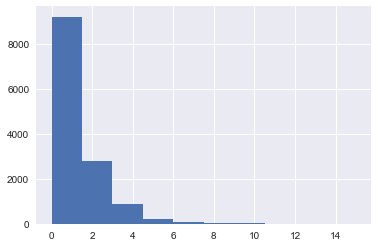

In [70]:
plt.hist(df_patents['sqrt_ncites'])

This distribution is still very skewed but better than it was previously. 

In [71]:
min(df_patents.date)

Timestamp('2001-08-07 00:00:00')

In [72]:
df_patents['days_since'] = (df_patents['date'] - pd.to_datetime('2001-08-07') ).astype('timedelta64[D]')
df_patents = df_patents.drop('date', axis=1)
df_patents.days_since = df_patents.days_since.astype('int64')
df_patents.head()

,id,type,number,country,abstract,title,kind,num_claims,topic,topics,...,pdate,permno,class,subclass,ncites,xi,sqrt_ncites,sqrt_claims,year,days_since
3459,6302513,utility,6302513,US,A process for depositing marking material ont...,Marking materials and marking processes therewith,A,12,85,"weight, polym",...,11/29/2001,27983.0,347.0,020000O,10.0,1.096928,3.162278,3.464102,2001,70
3487,6329227,utility,6329227,US,An organic polymer film patterning method inc...,Method of patterning organic polymer film and ...,A,15,85,"weight, polym",...,8/30/2001,53727.0,438.0,151000O,1.0,-2.251015,1.000000,3.872983,2001,126
3515,6355757,utility,6355757,US,The invention is directed to essentially satur...,Processing olefin copolymers,B2,11,85,"weight, polym",...,1/24/2002,11850.0,526.0,348000O,0.0,4.729758,0.000000,3.316625,2002,217
3529,6365650,utility,6365650,US,An adhesive suitable for bonding wood is both ...,Heat and radio frequency-curable two-pack soy ...,B1,12,85,"weight, polym",...,3/14/2002,24272.0,524.0,026000O,7.0,1.725626,2.645751,3.464102,2002,238
3550,6379500,utility,6379500,US,An aqueous silica-based sol comprising a nitro...,Silica-based sols,B2,69,85,"weight, polym",...,6/28/2001,75633.0,162.0,181600O,8.0,-0.808746,2.828427,8.306624,2002,266


In [73]:
df_patents['topic'] = df_patents['topic'].astype('category')

In [74]:
df_patent_full = df_patents.merge(df_patent_govt, on='number', how='left')
del df_patent_govt

In [75]:
df_patent_full.to_csv('patents_full.csv')
df_patent_full.head()

,id,type_x,number,country_x,abstract,title,kind,num_claims,topic,topics,...,sqrt_ncites,sqrt_claims,year,days_since,type_y,organization,country_y,latitude,longitude,gi
0,6302513,utility,6302513,US,A process for depositing marking material ont...,Marking materials and marking processes therewith,A,12,85,"weight, polym",...,3.162278,3.464102,2001,70,NaN,NaN,NaN,NaN,NaN,NaN
1,6329227,utility,6329227,US,An organic polymer film patterning method inc...,Method of patterning organic polymer film and ...,A,15,85,"weight, polym",...,1.000000,3.872983,2001,126,NaN,NaN,NaN,NaN,NaN,NaN
2,6355757,utility,6355757,US,The invention is directed to essentially satur...,Processing olefin copolymers,B2,11,85,"weight, polym",...,0.000000,3.316625,2002,217,NaN,NaN,NaN,NaN,NaN,NaN
3,6365650,utility,6365650,US,An adhesive suitable for bonding wood is both ...,Heat and radio frequency-curable two-pack soy ...,B1,12,85,"weight, polym",...,2.645751,3.464102,2002,238,NaN,NaN,NaN,NaN,NaN,NaN
4,6379500,utility,6379500,US,An aqueous silica-based sol comprising a nitro...,Silica-based sols,B2,69,85,"weight, polym",...,2.828427,8.306624,2002,266,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
df_patent_full.isnull().sum()

id                  0
type_x              0
number              0
country_x           0
abstract            0
title               0
kind                0
num_claims          0
topic               0
topics              0
fdate               0
idate               0
pdate               0
permno              0
class               0
subclass            0
ncites              0
xi                  0
sqrt_ncites         0
sqrt_claims         0
year                0
days_since          0
type_y          13073
organization    13073
country_y       13073
latitude        13073
longitude       13073
gi              13073
dtype: int64

it looks like from the data we added, only government influence will be useful as it is binary. Everything else has too many null values, so it would end up cutting our dataset too much to be useful, and we will likely be running into overfitting in that case. 

In [78]:
df_patent_full.shape

(16992, 28)

In [79]:
df_patent_full['gi'] = df_patent_full['gi'].fillna(0)

In [89]:
patent_values = df_patent_full['xi']

df_patents_smaller = df_patent_full.loc[:,['days_since', 'year', 'num_claims', 'sqrt_claims', 'topics', 'ncites', 'sqrt_ncites', 'xi', 'gi']]
x_patents = df_patent_full.loc[:,['number', 'days_since', 'year', 'num_claims', 'sqrt_claims', 'topics', 'ncites', 'sqrt_ncites', 'gi']]

In [90]:
df_patents_smaller.to_csv('patent_summary.csv')

In [91]:
df_patents.to_csv('df_patents.csv')

# Looking at the Distribution #  
  
from the pairplot, it looks like we are getting the most signal from the number of citations, unsurprisingly. "xi" is the patent value, "gi" is a binary indicator of government influence.  

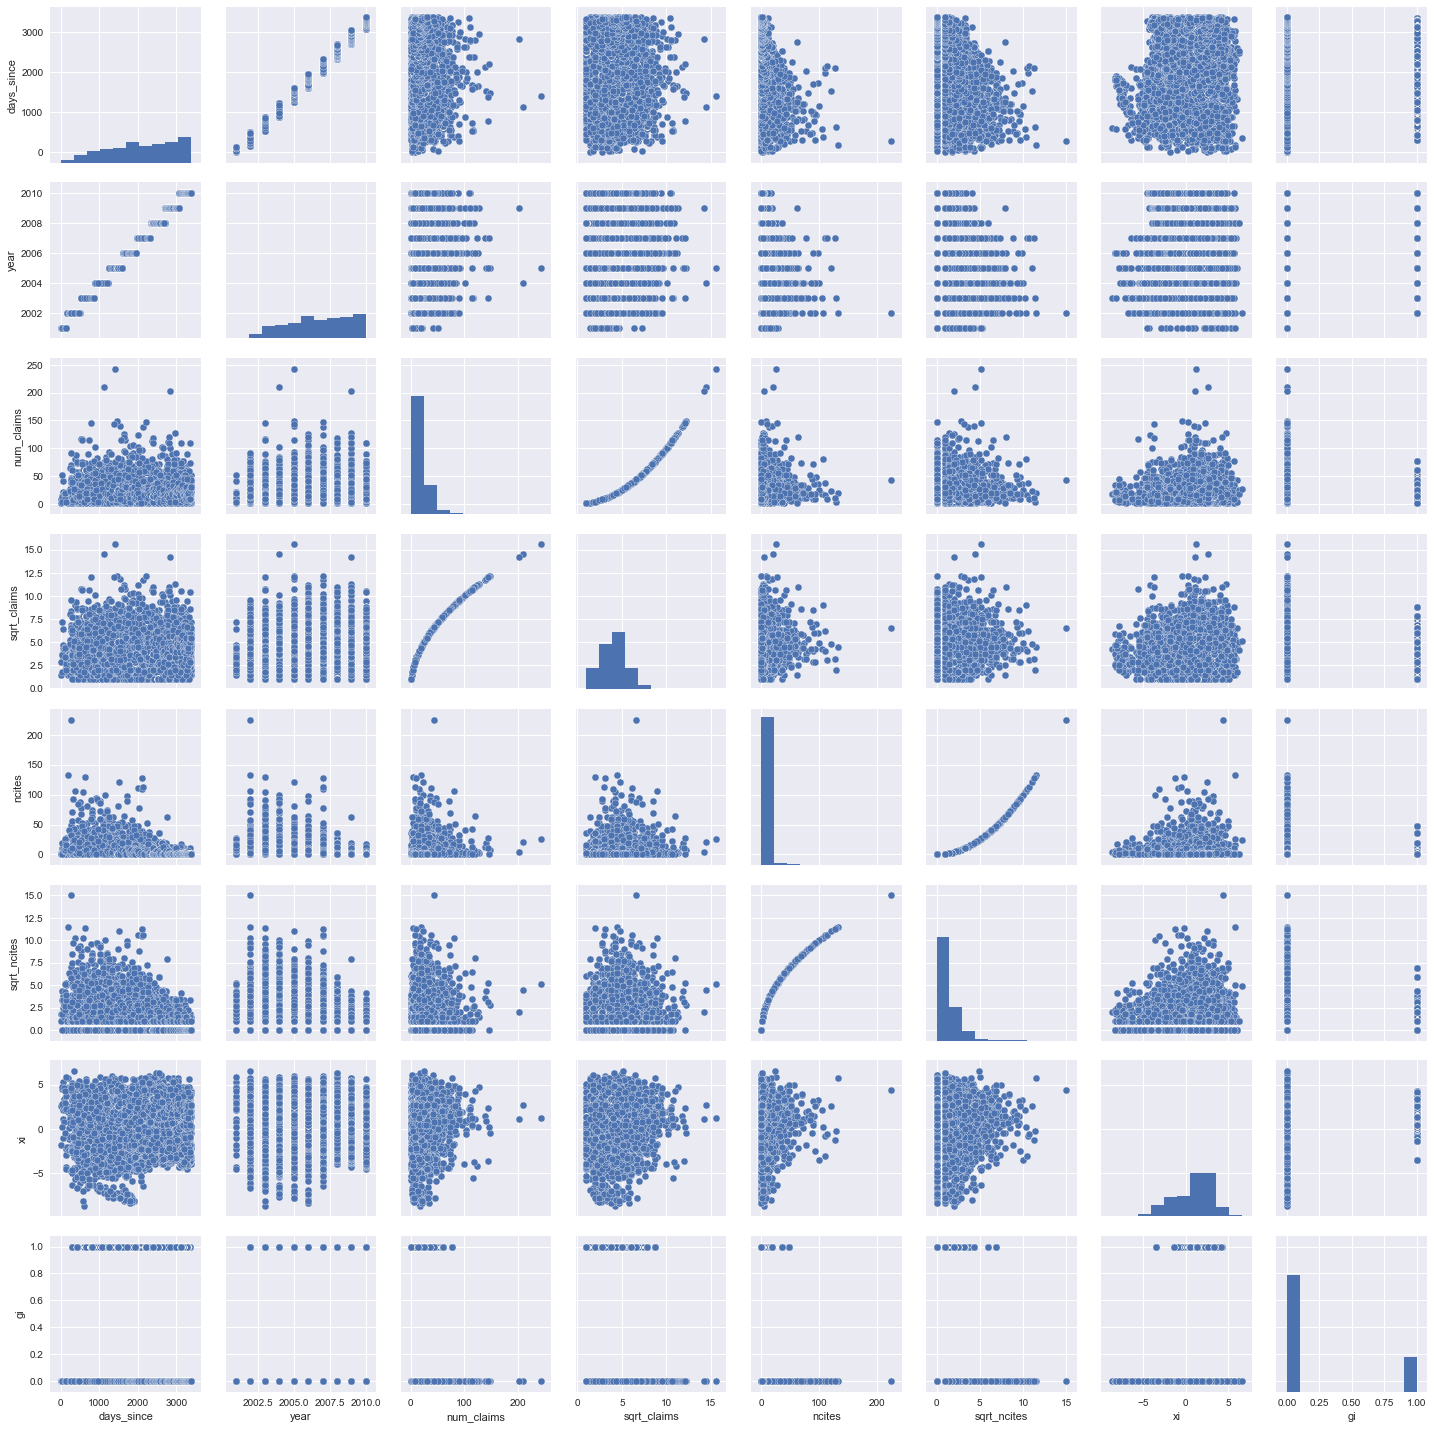

In [92]:
sns.pairplot(df_patents_smaller)

E:\Nicolas\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


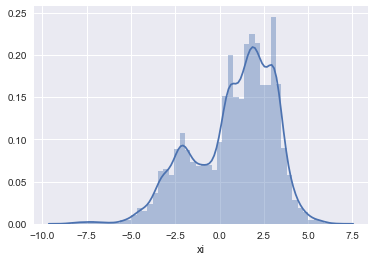

In [93]:
sns.distplot(patent_values)

In [94]:
len(df_patents['xi'])

13218

In [95]:
df_patents.topic = df_patents.topic.astype('str')

### Baseline ###  
  
I chose number of citations for the baseline model as from the pairplot it seemed to be most correlated with patent value

In [106]:
x_base, x_test_base, y_base, y_test_base = train_test_split(x_patents, patent_values)

In [107]:
x_base.isnull().sum()

number         0
days_since     0
year           0
num_claims     0
sqrt_claims    0
topics         0
ncites         0
sqrt_ncites    0
gi             0
dtype: int64

In [108]:
x_baseline = x_base.loc[:,['ncites']]
x_test_baseline = x_test_base.loc[:,['ncites']]

In [109]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

In [110]:
model = sm.OLS(y_base, sm.add_constant(x_baseline))
results = model.fit()
y_pred = results.predict(sm.add_constant(x_test_baseline))
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     xi   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     28.88
Date:                Mon, 07 Jan 2019   Prob (F-statistic):           7.82e-08
Time:                        19:05:11   Log-Likelihood:                -28426.
No. Observations:               12744   AIC:                         5.686e+04
Df Residuals:                   12742   BIC:                         5.687e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7566      0.022     34.859      0.000       0.714       0.799
ncites         0.0144      0.003      5.374      0.000       0.009       0.020
==============================================================================
Omnibus:                      845.752   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1025.709
Skew:                          -0.694   Prob(JB):                    1.86e-223
Kurtosis:                       3.051   Cond. No.                         8.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
type(y_pred)

pandas.core.series.Series

In [112]:
def single_regression_plot(x, y, y_pred):
    plt.figure(figsize=(20,5))

    plt.subplot(1, 3, 1)
    plt.scatter(x, y)
    plt.plot(x, y_pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res, alpha=0.2)
    plt.plot(np.linspace(-2,6,1000), np.linspace(0,0,1000))
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

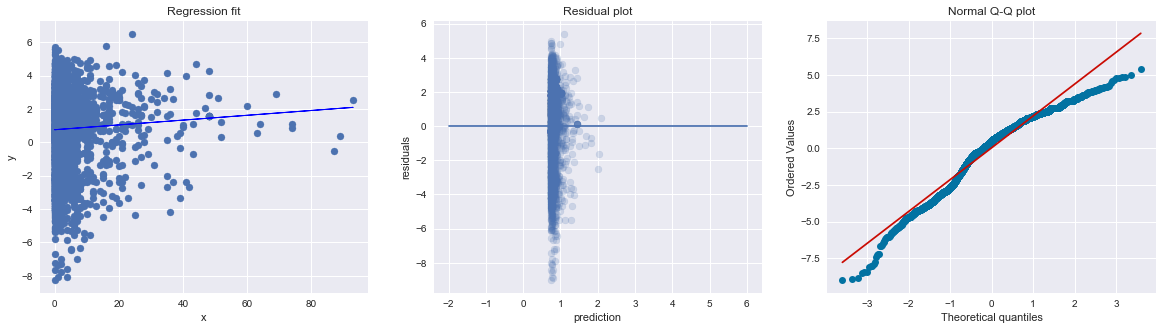

In [114]:
single_regression_plot(x_test_baseline, y_test_base, y_pred)

### Multiple Regression ##  
  
Now we can add more features, as well as dummy variable encoding, standardization and polynomial features to see how much signal we can get from a standard regression model. 

In [115]:
from sklearn.metrics import mean_squared_error
def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted)) 

In [116]:
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [117]:
alphavec = 10**np.linspace(-3,9,27)
steps = [('polynomial', PolynomialFeatures()), ('standardize', StandardScaler())]
pipe = Pipeline(steps)

In [126]:
selected = ['days_since', 'num_claims', 'topics', 'sqrt_ncites', 'gi', 'country_x']

In [127]:
x2 = pd.get_dummies(df_patent_full.loc[:,selected])
x2.head()

,days_since,num_claims,sqrt_ncites,gi,"topics_acid, nucleic","topics_agent, treatment","topics_air, cool","topics_antenna, radiat","topics_arm, pivot","topics_batteri, charg",...,"topics_user, content","topics_valv, close","topics_vehicl, wheel","topics_video, digit","topics_voltag, refer","topics_wall, upper","topics_water, pipe","topics_weight, polym","topics_wire, board",country_x_US
0,70,12,3.162278,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,126,15,1.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,217,11,0.000000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,238,12,2.645751,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,266,69,2.828427,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [128]:
x2_train, x2_test, y, y_test = train_test_split(x2, patent_values)

In [129]:
pipe.fit_transform(x2_train)
lm1 = LassoCV(alphas=alphavec, cv=kfold)
lm1.fit(x2_train, y)
y_pred = lm1.predict(x2_test)
scores = cross_val_score(lm1, x2_test, y_test, cv=kfold, scoring='mean_squared_error')
print('Multiple Linear regression val R^2: %.3f' 
      % lm1.score(x2_test, y_test))
print('Multiple Linear regression score val RMSE: %.3f' 
      % RMSE(lm1.predict(x2_test), y_test))
print(-scores)
print('Best Alpha: %.3f' 
      % lm1.alpha_)

E:\Nicolas\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
E:\Nicolas\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
E:\Nicolas\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


Multiple Linear regression val R^2: 0.210
Multiple Linear regression score val RMSE: 2.014
[3.97554143 3.74794033 4.47397686 4.09469183 4.31001284]
Best Alpha: 0.001


E:\Nicolas\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
E:\Nicolas\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [130]:
def multiple_regression_plot(x, y, y_pred):
    plt.figure(figsize=(20,5))

    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res, alpha=0.2)
    plt.plot(np.linspace(-2,4,1000), np.linspace(0,0,1000))
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

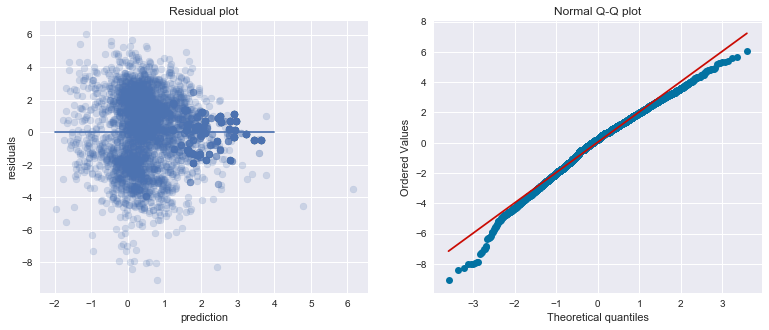

In [131]:
multiple_regression_plot(x2_test, y_test, y_pred)

<bound method Visualizer.poof of ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000189C5F6F6D8>,
       hist=True, line_color=None, model=None, test_color=None,
       train_color=None)>

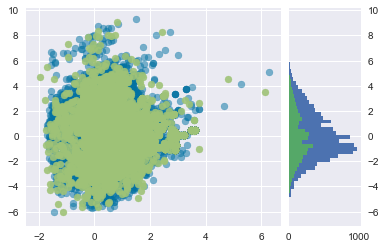

<Figure size 1080x504 with 0 Axes>

In [132]:
visualizer = ResidualsPlot(lm1, line_color='#111111')
visualizer.fit(x2_train, y)
visualizer.score(x2_test, y_test)
plt.figure(figsize = (15,7))
visualizer.poof

### Random Forest ###

Initially, I used SKLearn's Random Forest model but then I found a great visualization library called yellowbrick which I think gives better plots with more information than what I could get from matplotlib using the function I created. 

In [133]:
# parameters = {'n_estimators':[10], 'max_features':range(1,107), 'max_depth':range(1,15), 'n_jobs':[-1]}
# rf1 = RandomForestRegressor()
# grid = GridSearchCV(rf1, parameters)
#y_pred = rf1.predict(x2_test)

In [134]:
rf1 = RandomForestRegressor(n_estimators=100, max_features = 17, max_depth = 11, n_jobs = -1)

R-Squared: 0.249104


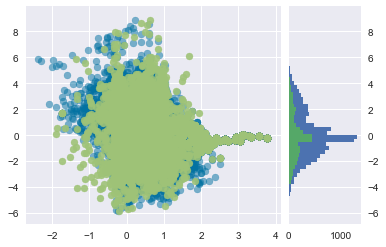

<Figure size 864x504 with 0 Axes>

In [135]:
visualizer = ResidualsPlot(rf1, line_color='#111111')
visualizer.fit(x2_train, y)
visualizer.score(x2_test, y_test)
plt.figure(figsize = (12,7))
visualizer.poof
print('R-Squared: %3f' %rf1.score(x2_test,y_test))

In [136]:
rf1.fit(x2_train, y)
y_pred = rf1.predict(x2_test)
scores = cross_val_score(rf1, x2_test, y_test, cv=kfold, scoring='mean_squared_error')
print('Multiple Linear regression val R^2: %.3f' 
      % rf1.score(x2_test, y_test))
print('Multiple Linear regression score val RMSE: %.3f' 
      % rmse(rf1.predict(x2_test), y_test))
print(-scores)

E:\Nicolas\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
E:\Nicolas\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
E:\Nicolas\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
E:\Nicolas\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
E:\Nicolas\Anaconda3\lib\site-packages\sklearn\m

Multiple Linear regression val R^2: 0.246
Multiple Linear regression score val RMSE: 1.967
[3.65927542 3.6082216  4.21506814 3.93151403 4.1703535 ]


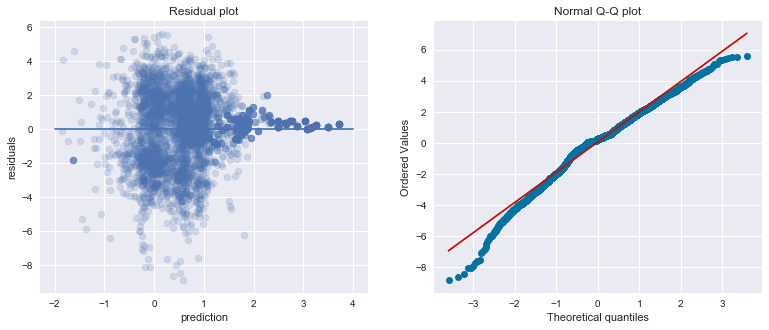

In [137]:
multiple_regression_plot(x2_test, y_test, y_pred)

In [138]:
sorted(zip(x2_train.columns,abs(rf1.feature_importances_)), key=lambda x: -x[1])

[('gi', 0.2903005453304177),
 ('num_claims', 0.2344850818939504),
 ('days_since', 0.1472969410724551),
 ('sqrt_ncites', 0.059304291954569086),
 ('topics_coat, adhes', 0.03954972289878331),
 ('topics_section, cross', 0.0314740707399069),
 ('topics_agent, treatment', 0.02453286885671412),
 ('topics_weight, polym', 0.013758341832362212),
 ('topics_record, medium', 0.013194056818086178),
 ('topics_electrod, electrolyt', 0.010093535647393343),
 ('topics_len, focus', 0.008563425468153005),
 ('topics_seal, ring', 0.007896579488763475),
 ('topics_pixel, array', 0.007861013709594064),
 ('topics_wire, board', 0.007492546305890449),
 ('topics_metal, alloy', 0.007153192505828036),
 ('topics_blade, cut', 0.007011454120108538),
 ('topics_measur, paramet', 0.006077057772670413),
 ('topics_magnet, field', 0.005758228523910008),
 ('topics_insul, conductor', 0.00477627856544535),
 ('topics_plate, hole', 0.004148300516443777),
 ('topics_acid, nucleic', 0.003961716317108521),
 ('topics_semiconductor, wafe

As we can see, the feature with the most signal is "gi", which stands for "government involvement". This is interesting since it indicates that a government has had its hand in some of the most valuable patents that have been developed (in this case the US government). This correlation is likely due to the fact that the government has in the past been very involved in cutting-edge research. Whether a patent is more value inherently due to government involvement would likely be an interesting further area of study. 

The next most valuable features are the number of claims, which likely indicates a more thorough patent that covers more ground, followed by "years since", which is a count of the number of years that have passed since the first patent in the dataset was granted. This indicates that patent values have been steadily increasing over time. Following this, the next strongest feature is the square root of the number of citations, which accounts for whether a patent is a "foundational patent", in other words, whether a patent is a breakthrough patent for a given technology. 

Finally, the rest of the features are the different topics that the patents cover, with chemical and pharmaceutical patents taking the top spots, followed by semiconductor manufacturing and battery technology. Tech patents would likely be higher on the list, however the technology topics are very fragmented due to the sheer explosion of patents in recent years compared to previously.

For further exploration, I would likely take the government involvement statements and do topic modelling on these as well in order to classify the level of government involvement to get some more clarity. 

### XGBoost ###

In [139]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       n_jobs=3,
                       max_depth=3,
                       objective="reg:linear",
                       learning_rate=.05, 
                       subsample=.6,
                       min_child_weight=12,
                       colsample_bytree=.8,
                      )

eval_set=[(x2_train,y),(x2_test,y_test)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    x2_train, y, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=50,
                    verbose=False
                   )
y_pred = gbm.predict(x2_test, ntree_limit=gbm.best_ntree_limit)

print(rmse(gbm.predict(x2_test, ntree_limit=gbm.best_ntree_limit),y_test))
print(r2_score(y_test, y_pred))

1.933235138728386
0.27207362113870415


In [ ]:
# visualizer2 = ResidualsPlot(gbm, line_color='#111111')
# visualizer2.fit(x2_train, y, eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50, verbose=False )
# visualizer2.score(x2_test, y_test                        )
# plt.figure(figsize = (12,7))
# visualizer2.poof

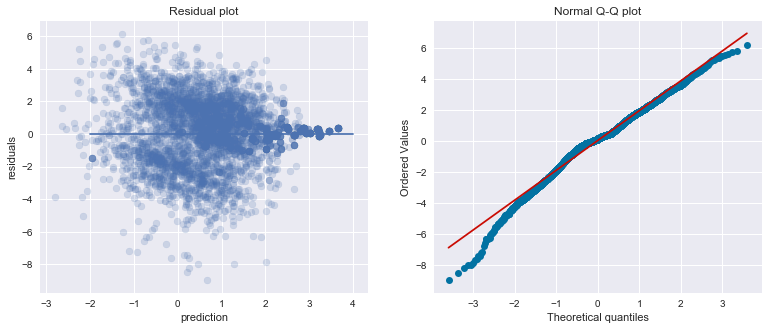

In [140]:
multiple_regression_plot(x2_test, y_test, y_pred)